# Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import torch
import matplotlib.pyplot as plt

In [3]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [4]:
DEVICE = torch.device('cuda')

In [5]:
%run ../utils/__init__.py
%run ../datasets/__init__.py
%run ../models/checkpoint/__init__.py
%run ../utils/nlp.py

In [6]:
config_logging(logging.INFO)

# Load data

In [7]:
kwargs = {
    'dataset_name': 'cxr14', # iu-x-ray
    'dataset_type': 'all',
    'batch_size': 25,
    'image_format': 'L',
    'frontal_only': True,
    'norm_by_sample': True,
    'image_size': (1024, 1024),
}

dataloader = prepare_data_classification(**kwargs)
len(dataloader.dataset)

[__main__] INFO(02-09 11:11) Loading cxr14/all cl-dataset, bs=25 imgsize=(1024, 1024) version=None format=L
[__main__] INFO(02-09 11:11) 	Dataset size: 112119


112119

# Load model

In [8]:
run_name = '1202_015907_jsrt_scan_lr0.0005_normS_size1024_wce1-6-3-3_aug10_sch-iou-p5-f0.5'
debug = False

In [9]:
compiled_model = load_compiled_model_segmentation(run_name, debug=debug, device=DEVICE)
compiled_model.metadata

{'model_kwargs': {'model_name': 'scan', 'n_classes': 4},
 'opt_kwargs': {'lr': 0.0005},
 'lr_sch_kwargs': {'mode': 'max',
  'threshold_mode': 'abs',
  'factor': 0.5,
  'patience': 5,
  'verbose': True},
 'hparams': {'loss_weights': [0.1, 0.6, 0.3, 0.3],
  'early_stopping': True,
  'early_stopping_kwargs': {'patience': 20, 'metric': 'iou', 'min_delta': 0},
  'lr_sch_metric': 'iou'},
 'dataset_kwargs': {'dataset_name': 'jsrt',
  'batch_size': 20,
  'image_size': [1024, 1024],
  'num_workers': 2,
  'norm_by_sample': True},
 'dataset_train_kwargs': {'shuffle': None,
  'augment': True,
  'augment_label': None,
  'augment_class': None,
  'augment_times': 10,
  'augment_kwargs': {'crop': 0.8,
   'translate': 0.1,
   'rotation': 15,
   'contrast': 0.8,
   'brightness': 0.8,
   'shear': [10, 10]}},
 'run_name': '1202_015907_jsrt_scan_lr0.0005_normS_size1024_wce1-6-3-3_aug10_sch-iou-p5-f0.5'}

# Segment images

And save masks

## Functions

In [10]:
from PIL import Image
from tqdm.notebook import tqdm

In [11]:
%run ../utils/shapes.py

In [12]:
def calculate_output(batch):
    images = batch.image.to(DEVICE)

    with torch.no_grad():
        outputs = compiled_model.model(images).detach().cpu()
        # shape: batch_size, n_labels, height, width

    _, outputs = outputs.max(dim=1)
    # shape: batch_size, height, width

    return outputs

In [13]:
def assertions(mask, image_fname):
    min_value = mask.min()
    if min_value != 0:
        print(f'[{image_fname}] Minimum must be zero, got {min_value}')
    
    max_value = mask.max()
    if max_value != 3:
        print(f'[{image_fname}] Maximum must be three, got {min_value}')

In [15]:
def get_filepath(masks_folder, image_name):
    filepath = os.path.join(masks_folder, image_name)
    if not filepath.endswith('.png'):
        filepath += '.png'
    return filepath

## Run segmentation

In [16]:
VERSION = 'v1'
EXIST_OK = True

In [17]:
masks_folder = os.path.join(dataloader.dataset.dataset_dir, 'masks', VERSION)
os.makedirs(masks_folder, exist_ok=EXIST_OK)

In [18]:
already_calculated = set(os.listdir(masks_folder))
len(already_calculated)

27554

In [19]:
len(dataloader.dataset), len(dataloader)

(112119, 4485)

In [20]:
# HACK: remove images that are already calculated
df = dataloader.dataset.label_index
df = df.loc[~df['FileName'].isin(already_calculated)]
df.reset_index(drop=True, inplace=True)
dataloader.dataset.label_index = df
len(dataloader.dataset), len(dataloader)

(84565, 3383)

In [ ]:
state = tqdm(total=len(dataloader.dataset))

for batch in dataloader:
    if all(image_name in already_calculated for image_name in batch.image_fname):
        state.update(len(batch.image_fname))
        continue
    
    outputs = calculate_output(batch).cpu()
    
    for image_name, mask in zip(batch.image_fname, outputs):
        if image_name in already_calculated:
            state.update(1)
            continue
            # raise Exception('Overriding previous mask!')

        mask = mask.to(torch.uint8).numpy()
        # shape: height, width
        
        assertions(mask, image_name)
        
        # Keep only largest shape:
        polygons = calculate_polygons(mask)
        largest_polygons = get_largest_shapes(polygons)
        mask = polygons_to_array(largest_polygons, mask.shape)

        assertions(mask, image_name)

        # Save to file
        mask = Image.fromarray(mask, mode='L')
        out_fpath = get_filepath(masks_folder, image_name)
        mask.save(out_fpath)

        state.update(1)

  0%|          | 0/84565 [00:00<?, ?it/s]

## Load one sample by name

To debug

In [77]:
df = dataloader.dataset.label_index
rows = df.loc[df['FileName'] == image_name]
indexes = list(rows.index)
assert len(indexes) > 0, f'No item found with fname {image_name}'
assert len(indexes) == 1, f'More than one item found: {rows}'
index = indexes[0]

In [89]:
item = dataloader.dataset[index]
item.image.size(), item.image.min(), item.image.max()

torch.Size([1, 1024, 1024])

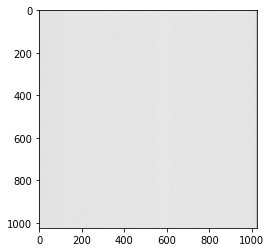

In [91]:
plt.imshow(tensor_to_range01(item.image[0]), cmap='gray')

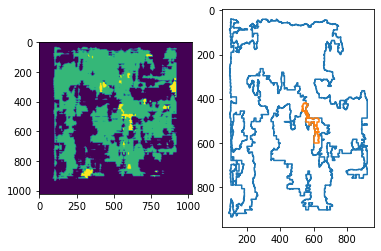

In [65]:
plt.subplot(1, 2, 1)
plt.imshow(mask)

plt.subplot(1, 2, 2)
plt.gca().invert_yaxis()
for coords, value in largest_polygons2:
    if len(coords) == 0:
        continue
    x_values, y_values = zip(*coords)
    plt.plot(x_values, y_values)

# Debug load dataset

In [46]:
%run ../utils/common.py

In [ ]:
%run ../datasets/iu_xray.py

dataset = IUXRayDataset('all', image_size=(1024, 1024), frontal_only=True, masks=True)
len(dataset)

In [47]:
%run ../datasets/cxr14.py

dataset = CXR14Dataset('all', image_size=(1024, 1024), frontal_only=True,
                       masks=True, masks_version='v1')
len(dataset)

112120

In [48]:
def squeeze_masks(masks):
    n_dim = len(item.masks.size())
    if n_dim == 2:
        return masks
    
    n_organs = item.masks.size(0)
    multiplier = torch.arange(0, n_organs).unsqueeze(-1).unsqueeze(-1)
    return (multiplier * item.masks).sum(dim=0)

In [52]:
item = dataset[1]
item.image.size(), item.masks.size(), item.image_fname

(torch.Size([3, 1024, 1024]), torch.Size([4, 1024, 1024]), '00000001_001.png')

(-0.5, 1023.5, 1023.5, -0.5)

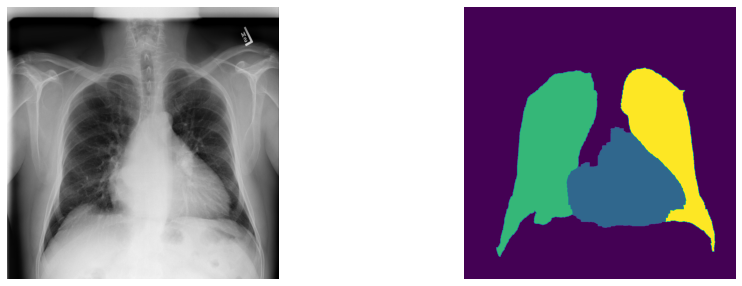

In [53]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(tensor_to_range01(item.image).permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(squeeze_masks(item.masks))
plt.axis('off')